In [ ]:
import backtrader as bt             # backtest engine & broker simulation
import pandas as pd                 # data manipulation
import pandas_ta as ta              # fast signal/indicator prototyping
import ccxt                         # unified crypto exchange API
import matplotlib
import matplotlib.pyplot as plt     # charting
from IPython.display import display
import plotly.graph_objects as go
plt.style.use('seaborn-v0_8-darkgrid')

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)    # make plots a good size

print('Backtrader:', bt.__version__)
print('Pandas:    ', pd.__version__)
print('pandas_ta: ', ta.__version__)
print('CCXT:      ', ccxt.__version__)
print('Matplotlib:', matplotlib.__version__)

Backtrader: 1.9.78.123
Pandas:     2.2.2
pandas_ta:  0.3.14b0
CCXT:       4.4.82
Matplotlib: 3.9.2


                        open     high      low    close     volume
timestamp                                                         
2025-05-15 08:00:00  90873.7  91348.9  90873.6  91245.3  18.322892
2025-05-15 09:00:00  91239.5  91240.8  90646.1  90899.7  24.888411
2025-05-15 10:00:00  90899.7  91050.9  90701.5  90941.0  57.365596
2025-05-15 11:00:00  90941.1  91608.3  90939.1  91608.2  21.376174
2025-05-15 12:00:00  91608.3  91740.0  91466.1  91542.6  56.478256


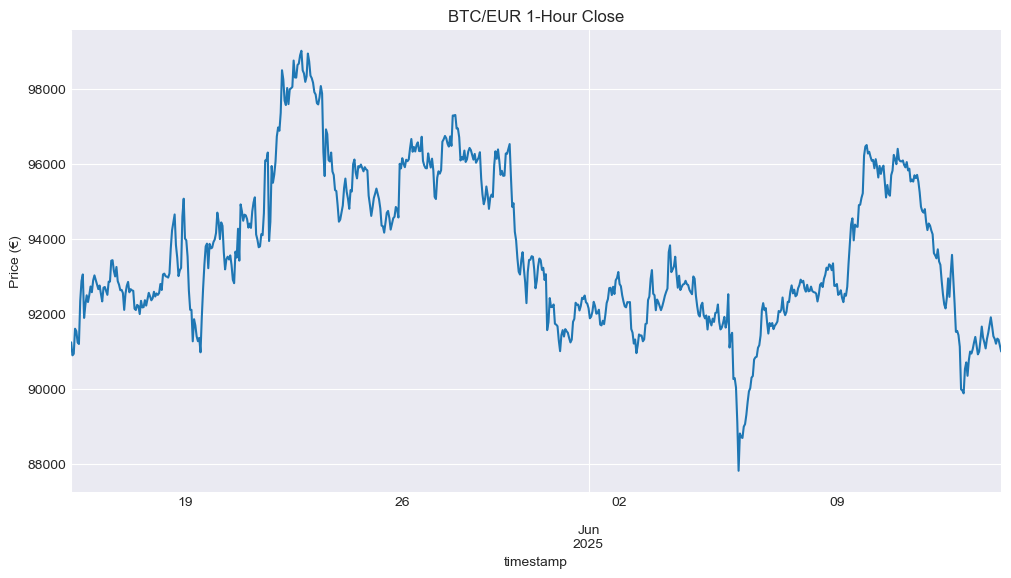

In [14]:
# 1. Instantiate the exchange
kr = ccxt.kraken()

# 2. Fetch recent OHLCV for BTC/EUR on a 1-hour timeframe
#    - limit=500 gives you ~500 hours of data; adjust as you like.
bars = kr.fetch_ohlcv('BTC/EUR', timeframe='1h', limit=1000)

# 3. Load into a pandas DataFrame
df = pd.DataFrame(bars, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])

# 4. Convert timestamp to datetime and set as index
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)

# 5. Inspect the first few rows
print(df.head())

# 6. Plot the closing price
df['close'].plot(title='BTC/EUR 1-Hour Close', ylabel='Price (€)')
plt.show()


In [15]:
# Calculate 14-period RSI on the close price
df['RSI_14'] = ta.rsi(df['close'], length=14)

# Peek at the new column
print(df[['close', 'RSI_14']].tail())

                       close     RSI_14
timestamp                              
2025-06-14 03:00:00  91209.0  45.362217
2025-06-14 04:00:00  91344.4  47.765278
2025-06-14 05:00:00  91315.2  47.282309
2025-06-14 06:00:00  91159.0  44.679751
2025-06-14 07:00:00  91001.9  42.165880


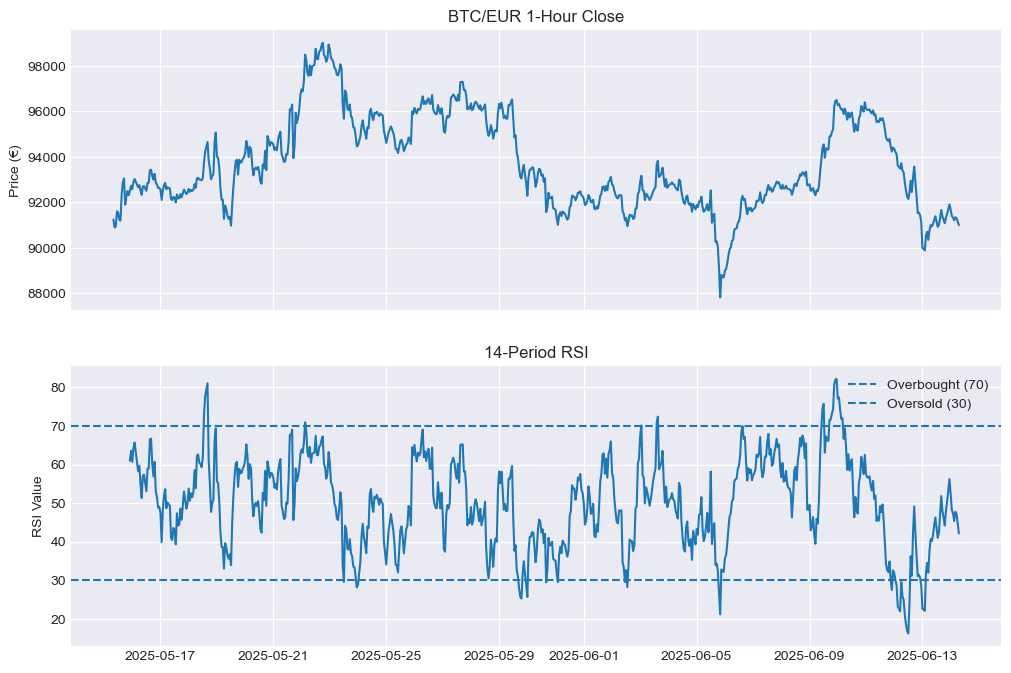

In [16]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 8))

# Top: BTC/EUR close price
axes[0].plot(df.index, df['close'])
axes[0].set_title('BTC/EUR 1-Hour Close')
axes[0].set_ylabel('Price (€)')

# Bottom: 14-period RSI with 30/70 lines
axes[1].plot(df.index, df['RSI_14'])
axes[1].axhline(70, linestyle='--', label='Overbought (70)')
axes[1].axhline(30, linestyle='--', label='Oversold (30)')
axes[1].set_title('14-Period RSI')
axes[1].set_ylabel('RSI Value')
axes[1].legend()

plt.show()


In [17]:
bb = ta.bbands(df["close"], length=20, std=2)

df = df.join(bb)

print(df[["close", "BBL_20_2.0", "BBM_20_2.0", "BBU_20_2.0"]].tail())

                       close    BBL_20_2.0  BBM_20_2.0    BBU_20_2.0
timestamp                                                           
2025-06-14 03:00:00  91209.0  90801.841619   91322.825  91843.808381
2025-06-14 04:00:00  91344.4  90851.055531   91342.690  91834.324469
2025-06-14 05:00:00  91315.2  90880.422703   91355.320  91830.217297
2025-06-14 06:00:00  91159.0  90871.251586   91351.320  91831.388414
2025-06-14 07:00:00  91001.9  90828.834588   91331.895  91834.955412


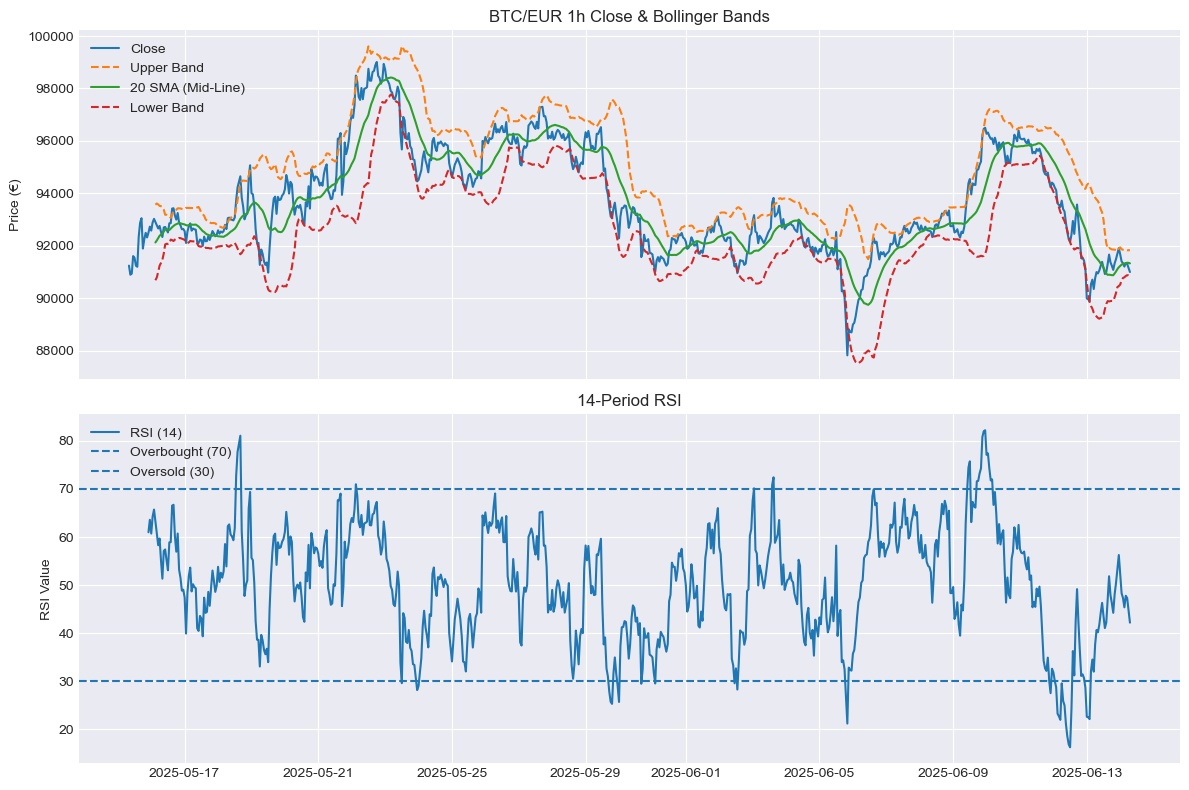

In [18]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 8))

# Top plot: price & Bands
axes[0].plot(df.index, df['close'], label='Close')
axes[0].plot(df.index, df['BBU_20_2.0'], linestyle='--', label='Upper Band')
axes[0].plot(df.index, df['BBM_20_2.0'], linestyle='-',  label='20 SMA (Mid-Line)')
axes[0].plot(df.index, df['BBL_20_2.0'], linestyle='--', label='Lower Band')
axes[0].set_title('BTC/EUR 1h Close & Bollinger Bands')
axes[0].set_ylabel('Price (€)')
axes[0].legend(loc='upper left')

# Bottom plot: your 14-period RSI
axes[1].plot(df.index, df['RSI_14'], label='RSI (14)')
axes[1].axhline(70, linestyle='--', label='Overbought (70)')
axes[1].axhline(30, linestyle='--', label='Oversold (30)')
axes[1].set_title('14-Period RSI')
axes[1].set_ylabel('RSI Value')
axes[1].legend(loc='upper left')

plt.tight_layout()
plt.show()


In [19]:
# Boolean mask: True whenever both conditions hold
df['long_signal'] = (df['close'] < df['BBL_20_2.0']) & (df['RSI_14'] < 30)

# How many long signals?
total_signals = df['long_signal'].sum()
print(f"Total long signals over {len(df)} bars: {total_signals}")

# What fraction of bars are signals?
pct = 100 * total_signals / len(df)
print(f"That's {pct:.2f}% of all bars.")

df.index[df['long_signal']]

Total long signals over 720 bars: 15
That's 2.08% of all bars.


DatetimeIndex(['2025-05-23 12:00:00', '2025-05-29 17:00:00',
               '2025-05-29 18:00:00', '2025-05-29 19:00:00',
               '2025-05-30 16:00:00', '2025-06-02 11:00:00',
               '2025-06-02 13:00:00', '2025-06-05 19:00:00',
               '2025-06-05 20:00:00', '2025-06-11 22:00:00',
               '2025-06-12 03:00:00', '2025-06-12 10:00:00',
               '2025-06-12 11:00:00', '2025-06-13 00:00:00',
               '2025-06-13 01:00:00'],
              dtype='datetime64[ns]', name='timestamp', freq=None)

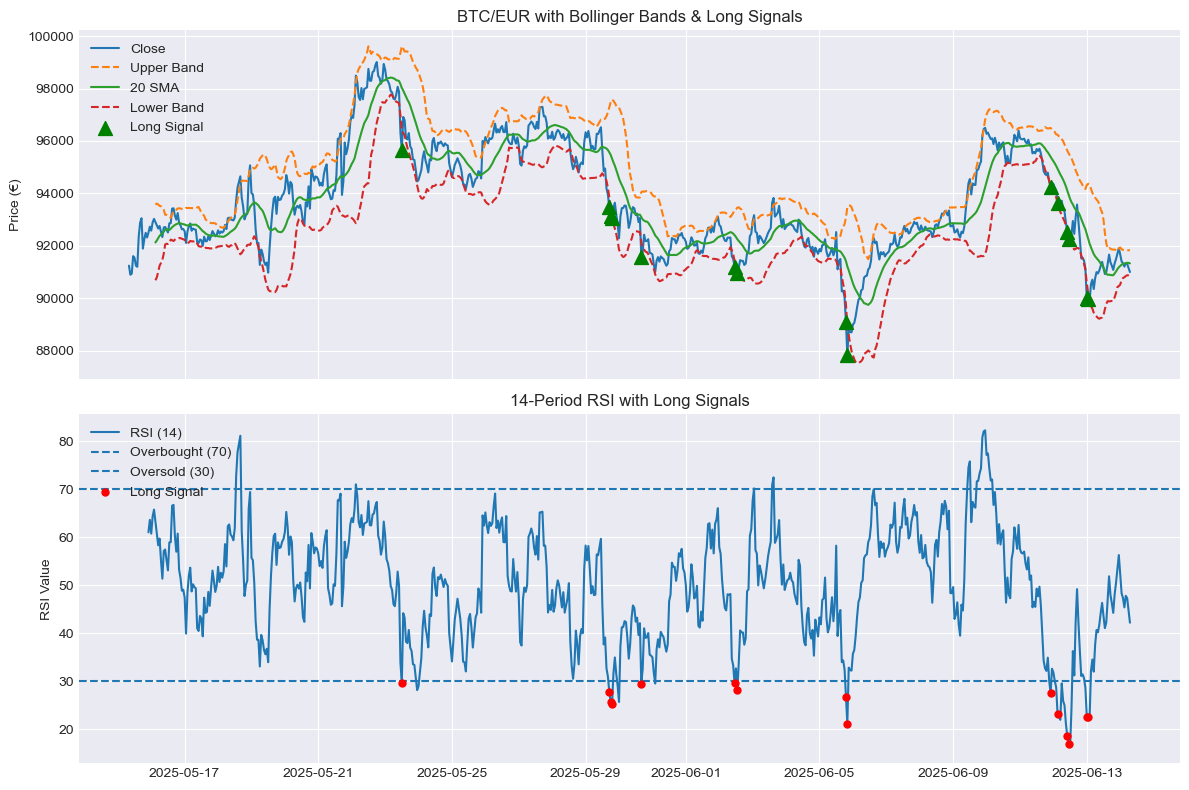

In [20]:
# === New cell: Plot BB + RSI with long‐signal markers ===

# Extract signal timestamps and values
signal_times  = df.index[df['long_signal']]
signal_prices = df.loc[signal_times, 'close']
signal_rsi    = df.loc[signal_times, 'RSI_14']

# Build the two‐panel chart
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 8))

# Top panel: Price + Bollinger Bands + markers
axes[0].plot(df.index, df['close'], label='Close')
axes[0].plot(df.index, df['BBU_20_2.0'], '--', label='Upper Band')
axes[0].plot(df.index, df['BBM_20_2.0'], '-',  label='20 SMA')
axes[0].plot(df.index, df['BBL_20_2.0'], '--', label='Lower Band')
axes[0].scatter(signal_times, signal_prices,
                marker='^', s=100, color='green',
                label='Long Signal', zorder=5)
axes[0].set_title('BTC/EUR with Bollinger Bands & Long Signals')
axes[0].set_ylabel('Price (€)')
axes[0].legend(loc='upper left')

# Bottom panel: RSI + markers
axes[1].plot(df.index, df['RSI_14'], label='RSI (14)')
axes[1].axhline(70, linestyle='--', label='Overbought (70)')
axes[1].axhline(30, linestyle='--', label='Oversold (30)')
axes[1].scatter(signal_times, signal_rsi,
                marker='.', s=100, color='red',
                label='Long Signal', zorder=5)
axes[1].set_title('14-Period RSI with Long Signals')
axes[1].set_ylabel('RSI Value')
axes[1].legend(loc='upper left')

plt.tight_layout()
plt.show()


In [21]:
class BBRSIMeanRev(bt.Strategy):
    params = dict(
        rsi_period = 14,
        bb_period  = 20,
        bb_dev     = 2.0,
        atr_period = 14,
    )

    def __init__(self):
        c = self.data.close
        # Indicators
        self.rsi = bt.ind.RSI(c, period=self.p.rsi_period)
        bb = bt.ind.BollingerBands(c,
                                   period=self.p.bb_period,
                                   devfactor=self.p.bb_dev)
        self.bb_low  = bb.bot
        self.bb_mid  = bb.mid
        self.bb_high = bb.top
        self.atr = bt.ind.ATR(period=self.p.atr_period)

    def next(self):
        if not self.position:
            # entry: close below lower band AND RSI < 30
            if self.data.close[0] < self.bb_low[0] and self.rsi[0] < 30:
                size = 0.05  # example fixed size
                self.buy(size=size)
        else:
            # exit: price ≥ mid‐line OR price < entry_price − ATR
            exit_mid  = self.data.close[0] >= self.bb_mid[0]
            stop_loss = self.data.close[0] < (self.position.price - self.atr[0])
            if exit_mid or stop_loss:
                self.close()

Final Equity: €4803.04
Sharpe Ratio: N/A
Max Drawdown: 7.17%
Total Trades: 8
Win Rate: 37.5%
Avg Win: 31.85   Avg Loss: -58.50
Profit Factor: 0.33


<IPython.core.display.Javascript object>

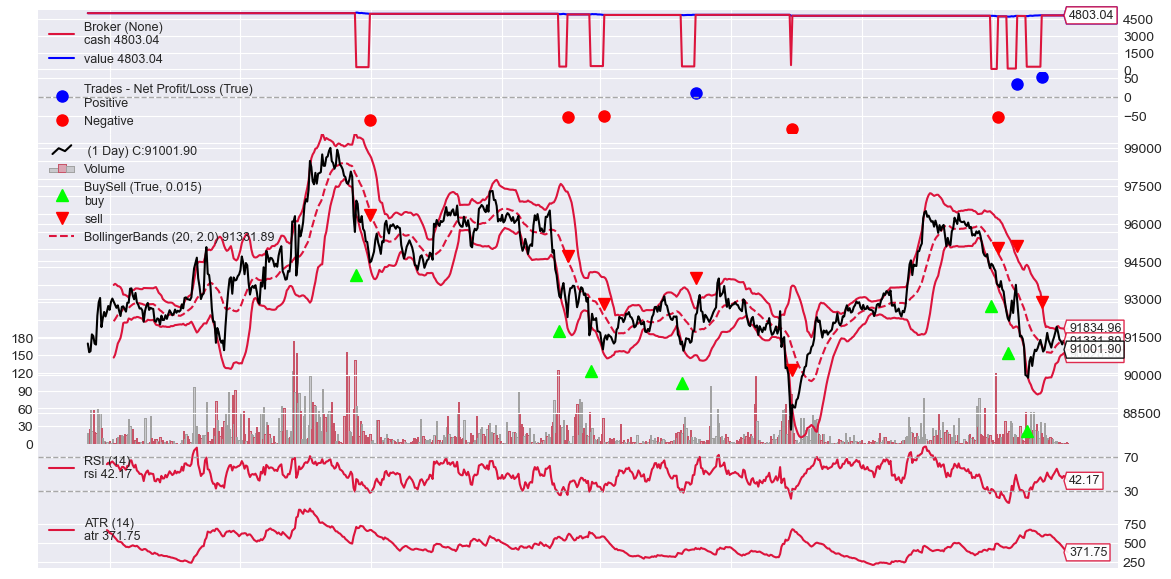

In [ ]:
# --- feed in the same DataFrame you built (or CSV) ---
data = bt.feeds.PandasData(dataname=df)  # if you want to reuse df directly

# 2. Initialize Cerebro and add components
cerebro = bt.Cerebro()
cerebro.adddata(data)
cerebro.addstrategy(BBRSIMeanRev)

# 3. Broker settings
cerebro.broker.setcash(5000)
cerebro.broker.setcommission(commission=0.0016)   # 0.16%
cerebro.broker.set_slippage_perc(perc=0.0005)     # 0.05%

# 4. Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')

# 5. Run strategy
results_list = cerebro.run()
if not results_list:
    raise RuntimeError("No strategy run—did you forget cerebro.adddata(data)?")
res = results_list[0]

# 6. Print basic PnL & risk stats
final_eq = cerebro.broker.getvalue()
print(f"Final Equity: €{final_eq:.2f}")

# Sharpe
sh = res.analyzers.sharpe.get_analysis()
raw_sr = sh.get('sharperatio', None)
if raw_sr is None:
    print("Sharpe Ratio: N/A")
else:
    print(f"Sharpe Ratio: {raw_sr:.2f}")

# Max drawdown
dd = res.analyzers.drawdown.get_analysis()
print(f"Max Drawdown: {dd.max.drawdown:.2f}%")

# 7. Safely extract TradeAnalyzer stats
ta = res.analyzers.trades.get_analysis()

# After you’ve extracted:
ntrades = ta.get('total', {}).get('closed',  0)
nwin    = ta.get('won',   {}).get('total',   0)
nloss   = ta.get('lost',  {}).get('total',   0)
avg_win  = ta.get('won',  {}).get('pnl', {}).get('average', 0.0)
avg_loss = ta.get('lost', {}).get('pnl', {}).get('average', 0.0)

# Total gross wins and losses
gross_win  = avg_win  * nwin
gross_loss = avg_loss * nloss     # avg_loss is negative, so this is negative

# Profit Factor = gross wins / abs(gross losses)
if gross_loss != 0:
    pfactor = gross_win / abs(gross_loss)
else:
    pfactor = float('0.0')  # or 0.0, whichever you prefer

# 8. Print trade metrics
print(f"Total Trades: {ntrades}")
if ntrades:
    win_rate = nwin / ntrades * 100
    print(f"Win Rate: {win_rate:.1f}%")
print(f"Avg Win: {avg_win:.2f}   Avg Loss: {avg_loss:.2f}")
print(f"Profit Factor: {pfactor:.2f}")

# 9. Plot trades & equity curve
figs = cerebro.plot()   # nested list of lists of matplotlib.Figure
for fig_list in figs:
    for fig in fig_list:
        display(fig)


In [29]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import Span
from bokeh.layouts import column

# 1) Inline output
output_notebook()

# 2) Setup candle width (0.8 × 1 hour in ms)
w = 0.8 * 3600 * 1000

# 3) Price & BB figure
p1 = figure(
    x_axis_type="datetime",
    tools="pan,wheel_zoom,reset,save",
    active_drag="pan",
    active_scroll="wheel_zoom",
    sizing_mode="stretch_width",
    height=350,
    title="BTC/EUR 1h — Price, BB, Entries/Exits"
)

# Split into rising/falling
inc = df['close'] >= df['open']
dec = ~inc

# Wick (high-low)
p1.segment(df.index, df['high'], df.index, df['low'], line_color="black")
# Up candles
p1.vbar(df.index[inc],   w, df['open'][inc],  df['close'][inc],
        fill_color="#44aa44", line_color="black")
# Down candles
p1.vbar(df.index[dec],   w, df['open'][dec],  df['close'][dec],
        fill_color="#aa4444", line_color="black")

# Bollinger Bands
p1.line(df.index, df['BBU_20_2.0'], line_dash="dashed", color="red",   legend_label="Upper BB")
p1.line(df.index, df['BBM_20_2.0'],                     color="black", legend_label="Mid BB")
p1.line(df.index, df['BBL_20_2.0'], line_dash="dashed", color="green", legend_label="Lower BB")

# Entry & Exit markers
p1.triangle(signal_times, signal_prices,       size=12, color="blue", legend_label="Entry")
p1.inverted_triangle(exit_times, exit_prices,  size=12, color="red",  legend_label="Exit")

p1.legend.location = "top_left"
p1.yaxis.axis_label = "Price (€)"


# 4) RSI subplot (linked x‐range)
p2 = figure(
    x_axis_type="datetime",
    x_range=p1.x_range,
    tools="pan,wheel_zoom,reset,save",
    active_drag="pan",
    active_scroll="wheel_zoom",
    sizing_mode="stretch_width",
    height=150,
    title="14‐Period RSI"
)

p2.line(df.index, df['RSI_14'], color="navy")
for thresh in (70, 30):
    p2.add_layout(Span(location=thresh, dimension="width",
                       line_dash="dashed", line_color="gray"))
p2.yaxis.axis_label = "RSI"


# 5) Show them stacked
show(column(p1, p2))


Loading BokehJS ...

NameError: name 'exit_times' is not defined